In [2]:
import yaml
import sys
import torch
import numpy as np
from pathlib import Path
from prodict import Prodict

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

BASE_DIR = "/home/robesafe/libraries/SoPhie"

sys.path.append(BASE_DIR)

from sophie.utils.utils import relative_to_abs_sgan
from sophie.models.mp_so import TrajectoryGenerator
from sophie.data_loader.argoverse.dataset_sgan_version import ArgoverseMotionForecastingDataset, seq_collate
from sophie.trainers.trainer_sophie_adaptation import cal_ade, cal_fde

## Load config 

In [3]:
config_dir = BASE_DIR + "/configs/sophie_argoverse.yml"
with open(config_dir) as config:
    config = yaml.safe_load(config)
    config = Prodict.from_dict(config)
    config.base_dir = BASE_DIR

# Fill some additional dimensions

past_observations = config.hyperparameters.obs_len
num_agents_per_obs = config.hyperparameters.num_agents_per_obs
config.sophie.generator.social_attention.linear_decoder.out_features = past_observations * num_agents_per_obs

## Load dataset

In [4]:
split_percentage = 0.005
batch_size = 1

config.dataset.path = BASE_DIR + "/" + "data/datasets/argoverse/motion-forecasting/"

config.dataset.split = "val"
config.dataset.split_percentage = 0.005 # To generate the final results, must be 1 (whole split test)
config.dataset.batch_size = 1 # Better to build the h5 results file
config.dataset.num_workers = 0
config.dataset.class_balance = -1.0 # Do not consider class balance in the split test
config.dataset.shuffle = False

data = ArgoverseMotionForecastingDataset(dataset_name=config.dataset_name,
                                                 root_folder=config.dataset.path,
                                                 obs_len=config.hyperparameters.obs_len,
                                                 pred_len=config.hyperparameters.pred_len,
                                                 distance_threshold=config.hyperparameters.distance_threshold,
                                                 split="val",
                                                 num_agents_per_obs=config.hyperparameters.num_agents_per_obs,
                                                 split_percentage=split_percentage,
                                                 shuffle=False)

data_val = ArgoverseMotionForecastingDataset(dataset_name=config.dataset_name,
                                                root_folder=config.dataset.path,
                                                obs_len=config.hyperparameters.obs_len,
                                                pred_len=config.hyperparameters.pred_len,
                                                distance_threshold=config.hyperparameters.distance_threshold,
                                                split=config.dataset.split,
                                                num_agents_per_obs=config.hyperparameters.num_agents_per_obs,
                                                split_percentage=config.dataset.split_percentage,
                                                shuffle=config.dataset.shuffle,
                                                batch_size=config.dataset.batch_size,
                                                class_balance=config.dataset.class_balance,
                                                obs_origin=config.hyperparameters.obs_origin)

loader = DataLoader(data_val,
                            batch_size=config.dataset.batch_size,
                            shuffle=config.dataset.shuffle,
                            num_workers=config.dataset.num_workers,
                            collate_fn=seq_collate)

Num files:  39472
Start Dataset
Dataset time:  1.3086674213409424


## Load generator from checkpoint

In [5]:
# model_path = "/home/robesafe/tmp/exp9_argoverse_motion_forecasting_dataset_0_with_model.pt"
exp_name = "gen_exp/exp7"
model_path = BASE_DIR + "/save/argoverse/" + exp_name + "/argoverse_motion_forecasting_dataset_0_with_model.pt"
checkpoint = torch.load(model_path)
generator = TrajectoryGenerator(config.sophie.generator)
generator.load_state_dict(checkpoint.config_cp['g_best_state'])
generator.cuda() # Use GPU
generator.eval()

TrajectoryGenerator(
  (encoder): EncoderLSTM(
    (encoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
  )
  (lne): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (sattn): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (W_q): Linear(in_features=32, out_features=32, bias=False)
    (W_k): Linear(in_features=32, out_features=32, bias=False)
    (W_v): Linear(in_features=32, out_features=32, bias=False)
    (W_o): Linear(in_features=32, out_features=32, bias=False)
  )
  (decoder): TemporalDecoderLSTM(
    (decoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=40, out_features=16, bias=True)
    (ln1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (hidden2pos): Linear(in_features=32, out_features=2, bias=True)
    (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (lnc): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp

## Run test

In [6]:
num_samples = 5
output_all = []

ade_list = []
fde_list = []

with torch.no_grad():
    for batch_index, batch in enumerate(loader):
        if batch_index > 99:
            break
        batch = [tensor.cuda() for tensor in batch]
        
        (obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_obj,
            loss_mask, seq_start_end, frames, object_cls, obj_id, ego_origin, nsl,_) = batch

        predicted_traj = []
        agent_idx = torch.where(object_cls==1)[0].cpu().numpy()
        traj_real = torch.cat([obs_traj, pred_traj_gt], dim=0) + ego_origin.permute(1,0,2)
        predicted_traj.append(traj_real[:, agent_idx,:])
        print(agent_idx.shape, agent_idx)
        for _ in range(num_samples):
            # Get predictions
            pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end, agent_idx)

            agent_obj_id = obj_id[agent_idx]

            # Get predictions in absolute coordinates
            pred_traj_fake = relative_to_abs_sgan(pred_traj_fake_rel, obs_traj[-1,agent_idx, :]) # 30,1,2
            traj_fake = torch.cat([obs_traj[:,agent_idx, :], pred_traj_fake], dim=0) + ego_origin.permute(1,0,2) # 50,1,2
            predicted_traj.append(traj_fake)
        
        predicted_traj = torch.stack(predicted_traj, axis=0)
        predicted_traj = predicted_traj.cpu().numpy()
        if batch_index == 61:
            print(f" {batch_index} - {nsl}")
        output_all.append(predicted_traj)

(1,) [2]
(1,) [1]
(1,) [11]
(1,) [2]
(1,) [3]
(1,) [2]
(1,) [1]
(1,) [2]
(1,) [1]
(1,) [5]
(1,) [1]
(1,) [1]
(1,) [14]
(1,) [2]
(1,) [2]
(1,) [3]
(1,) [3]
(1,) [2]
(1,) [2]
(1,) [2]
(1,) [6]
(1,) [2]
(1,) [1]
(1,) [21]
(1,) [1]
(1,) [3]
(1,) [3]
(1,) [2]
(1,) [3]
(1,) [5]
(1,) [1]
(1,) [1]
(1,) [14]
(1,) [7]
(1,) [1]
(1,) [1]
(1,) [4]
(1,) [12]
(1,) [7]
(1,) [1]
(1,) [15]
(1,) [7]
(1,) [2]
(1,) [1]
(1,) [6]
(1,) [2]
(1,) [2]
(1,) [2]
(1,) [3]
(1,) [5]
(1,) [19]
(1,) [2]
(1,) [1]
(1,) [1]
(1,) [1]
(1,) [3]
(1,) [1]
(1,) [14]
(1,) [7]
(1,) [3]
(1,) [1]
(1,) [2]
 61 - tensor([63], device='cuda:0', dtype=torch.int32)
(1,) [6]
(1,) [2]
(1,) [3]
(1,) [3]
(1,) [11]
(1,) [2]
(1,) [2]
(1,) [3]
(1,) [1]
(1,) [2]
(1,) [5]
(1,) [1]
(1,) [1]
(1,) [15]
(1,) [1]
(1,) [5]
(1,) [1]
(1,) [1]
(1,) [16]
(1,) [7]
(1,) [17]
(1,) [1]
(1,) [1]
(1,) [1]
(1,) [1]
(1,) [2]
(1,) [3]
(1,) [4]
(1,) [9]
(1,) [4]
(1,) [4]
(1,) [1]
(1,) [4]
(1,) [5]
(1,) [1]
(1,) [1]
(1,) [1]
(1,) [6]


## Show trajectories

predicted_traj  (6, 50, 1, 2)


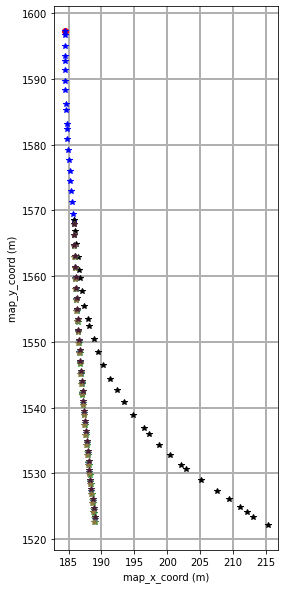

In [22]:
import matplotlib
ax = plt.gca()
# 12, 13, 14
predicted_traj = output_all[71] 
# Good example: 95
# Very challenging: 71
# Almost impossible: 
print("predicted_traj ", predicted_traj.shape)
with plt.rc_context({'xtick.color': 'white', 'ytick.color': 'white'}):
    plt.grid(linestyle='-', linewidth=2)
    plt.plot(predicted_traj[0,0,0,0],predicted_traj[0,0,0,1],'-o',c='r') #starting point here
    plt.plot(predicted_traj[0,:21,:,0],predicted_traj[0,:21,:,1],'*',c='b')

    for i in range(predicted_traj.shape[0]):
        if i == 0:
            c = 'black'
        else:
            c= np.random.rand(3,)
        plt.plot(predicted_traj[i,20:,:,0],predicted_traj[i,20:,:,1],'*',c=c)#np.random.rand(3,)
    plt.xlabel('map_x_coord (m)')
    plt.ylabel('map_y_coord (m)')

    ax.set_aspect('equal')
    ax.figure.set_size_inches(10,10)
    plt.show()